# Univariate regression to predict the wind speed field

In [1]:
import torch
import torch.nn as nn
import numpy as np

from utils.metrics import MetricsLogger
from utils.data_loaders import get_wake_dataloaders
import utils.utils as uutils
import utils.data_utils as data_utils
import utils.plotting as plotting

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [2]:
HIDDEN_LAYERS_UNITS = [50, 250]

class UnivariateNN(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(UnivariateNN, self).__init__()
        layer_units = [input_space] + HIDDEN_LAYERS_UNITS + [output_space]
        layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            layers += [nn.Linear(first, second), nn.ReLU()]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [3]:
FACTORS_FOLDER = "discr_factors_x2_50_y-1_1_step0.125_TIstep0.02_CTstep0.02"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
MODEL_NAME = f"univariate_NN_layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
CONSIDER_WS = False
COORDS_AS_INPUT = True # univariate setting
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"\
        .replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
    print(MODEL_NAME)
    print(BEST_MODEL_PATH)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{DEVICE=}")

# hyperparameters
# in univariate, the batch size is a multiplier for number of cells
# (i.e. the batch_size should be dividible by the number of cells)
BATCH_MULTIPLIER = 1
EPOCHS = 500
LR = 0.0000001

DEVICE=device(type='cpu')


In [4]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATA_FOLDER,
                                                          consider_ws=CONSIDER_WS,
                                                          coords_as_input=COORDS_AS_INPUT,
                                                          train_perc=0.6,
                                                          test_perc=0.2,
                                                          validation_perc=0.2,
                                                          batch_multiplier=BATCH_MULTIPLIER)
len(train_dataloader)

1290

In [5]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

input_space = train_dataloader.dataset.x.shape[1]
output_space = train_dataloader.dataset.y.shape[1]
print(f"{input_space=}\t{output_space=}")

torch.Size([6144, 4]) torch.Size([6144, 1])
input_space=4	output_space=1


input_space=4	output_space=1
Logging UnivariateNN training
Epoch 0 ->	Training loss=0.001774768390240345	Validation loss=0.0018866550265793567	
Epoch 1 ->	Training loss=0.0015607621923417066	Validation loss=0.0014480038286252708	
Epoch 2 ->	Training loss=0.0011026152052959603	Validation loss=0.000997302120826508	
Epoch 3 ->	Training loss=0.0007998997371295814	Validation loss=0.000825975277513965	
Epoch 4 ->	Training loss=0.0006998544660313698	Validation loss=0.0007497215820757602	
Epoch 5 ->	Training loss=0.0006419395622772117	Validation loss=0.000693667141996024	
Epoch 6 ->	Training loss=0.0005975415299258731	Validation loss=0.0006497458324682566	
Epoch 7 ->	Training loss=0.0005621692927696234	Validation loss=0.0006142894695386685	
Epoch 8 ->	Training loss=0.0005335989234004458	Validation loss=0.0005854114689948143	
Epoch 9 ->	Training loss=0.0005103369847338094	Validation loss=0.000561410087306745	
Epoch 10 ->	Training loss=0.0004910802246754887	Validation loss=0.0005413351147823638	

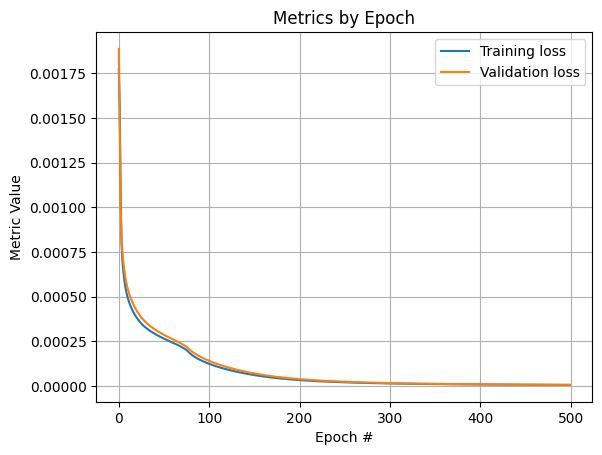

Metrics exported in the following csv file: logged_metrics/UnivariateNNtraining_metrics_20-05-2023_12-54-52.csv


In [5]:
model = UnivariateNN(input_space, output_space).to(DEVICE)

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=LR
)
loss_function = torch.nn.MSELoss()

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    model.train(True)
    epoch_tloss = 0
    for batch in iter(train_dataloader):
        x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()
        prediction = model(x)
        tloss = loss_function(prediction, y)
        tloss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_tloss += tloss.item() * x.size(0)
        #TODO accuracy or other metric computation????

    avg_tloss = epoch_tloss / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss', avg_tloss)

    '''VALIDATION'''
    if valid_dataloader:
        model.train(False)
        epoch_vloss = 0
        for batch in iter(valid_dataloader):
            x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
            prediction = model(x)
            vloss = loss_function(prediction, y)

            epoch_vloss += vloss.item() * x.size(0)

        avg_vloss = epoch_vloss / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss', avg_vloss)
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), BEST_MODEL_PATH)


metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

# Testing

In [6]:
# loading best model
model = UnivariateNN(input_space, output_space).to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.train(False)
loss_function = torch.nn.MSELoss()

total_loss = 0
total_deficit = 0
with torch.no_grad():
    for batch in iter(test_dataloader):
        # to device
        x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)

        prediction = model(x)
        tloss = loss_function(prediction, y)

        total_loss += tloss.item() * x.size(0)
        total_deficit += y.sum()

avg_loss = total_loss / len(test_dataloader.sampler)
avg_deficit = total_deficit / len(test_dataloader.sampler)
print(f"Testing results: avg loss={avg_loss} on an avg deficit per wake of {avg_deficit}")

Testing results: avg loss=5.958865311154219e-06 on an avg deficit per wake of 0.022109532728791237


6144
num_fields=430
2641920
max_deficit=tensor(0.3246)


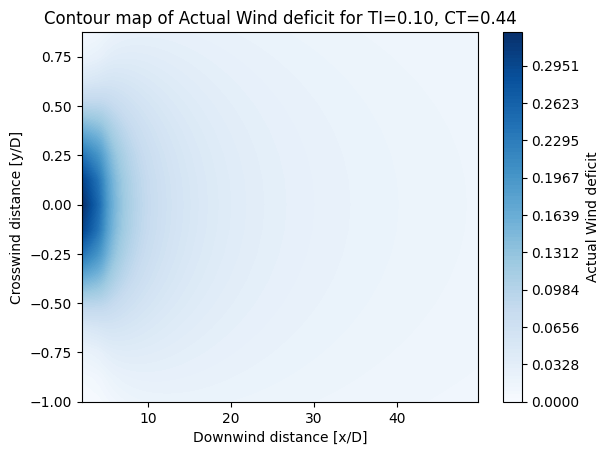

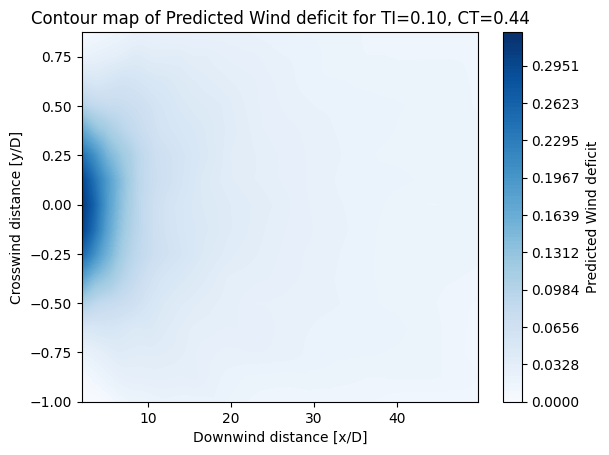

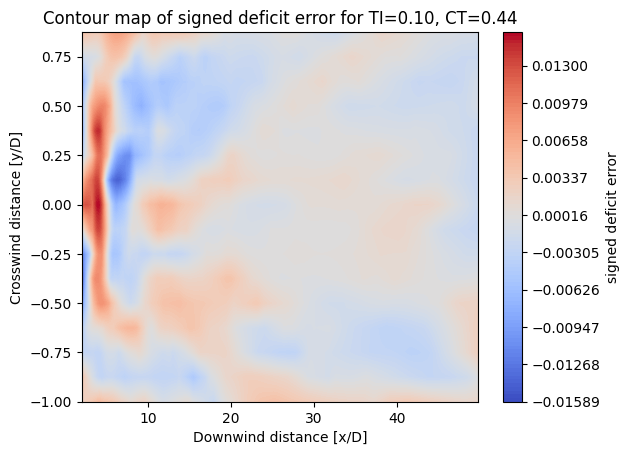

In [19]:
num_cells = test_dataloader.dataset.num_cells
print(num_cells)
num_fields = int(len(test_dataloader)/BATCH_MULTIPLIER)
print(f"{num_fields=}")
print(len(test_dataloader.sampler))

with torch.no_grad():
    for field_idx in range(num_fields):
        inputs, outputs = test_dataloader.dataset[field_idx:field_idx+num_cells]
        unscaled_inputs = torch.Tensor(test_dataloader.dataset.unscaled_x[field_idx:field_idx+num_cells])
        predictions = model(inputs)

        if CONSIDER_WS:
            ti, ct, X, Y, ws = unscaled_inputs[0, 0], unscaled_inputs[0, 1], \
                unscaled_inputs[:, 2], unscaled_inputs[:, 3], unscaled_inputs[:, 4]
        else:
            ti, ct, X, Y = unscaled_inputs[0, 0], unscaled_inputs[0, 1], \
                unscaled_inputs[:, 2], unscaled_inputs[:, 3]
            ws = None
        
        # correctly reshape X, Y, outputs and predictions
        trasp_shape = len(X.unique()), len(Y.unique())
        X = X.reshape(trasp_shape).T
        Y = Y.reshape(trasp_shape).T
        wake_field = outputs.view(-1).reshape(trasp_shape).T
        predicted_wake_field = predictions.view(-1).reshape(trasp_shape).T
        
        plotting.plot_maps(X, Y, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='signed')
        break